# Setting up

In [6]:
!pip install -qq sentencepiece
!pip install -qq transformers==4.7.0
!pip install -qq unidecode

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [3]:
!gdown --id -qq 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id -qq 141nsJ-dt-ZDR0aM1GkY2CGEmKeIM7O1F
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!unzip -qq wassa_dataset.zip
!rm wassa_dataset.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
To: /content/codes.json
100% 216k/216k [00:00<00:00, 12.6MB/s]


In [7]:
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import torch.utils
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
import re
import unidecode
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import MT5Tokenizer
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, AlbertModel, AlbertTokenizer, AutoModel, AutoTokenizer

ImportError: cannot import name 'GenerationMixin' from 'transformers.generation' (/usr/local/lib/python3.12/dist-packages/transformers/generation/__init__.py)

In [ ]:
nltk.download("all")

# Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

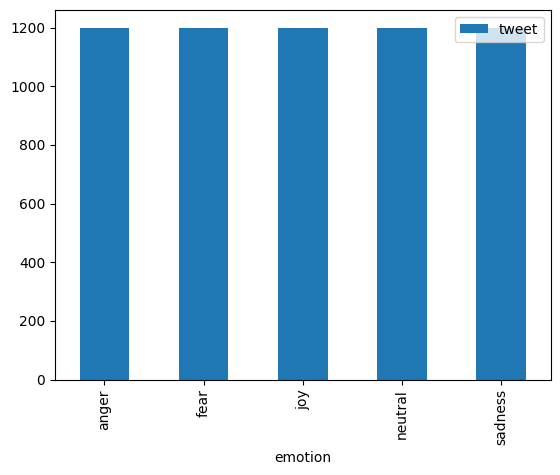

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [6]:
df_train = pd.read_csv(r"/content/wassa_train.csv")
df_val   = pd.read_csv(r"/content/wassa_val.csv")
df_test  = pd.read_csv(r"/content/wassa_test.csv")

n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()

print(n_samples)

In [8]:
emotions_list=["joy", "anger", "fear", "sadness", "neutral"]

In [9]:
texts_train = df_train.tweet.tolist()
texts_val = df_val.tweet.tolist()
texts_test = df_test.tweet.tolist()

label_encoder = LabelEncoder()
emotions_train = label_encoder.fit_transform(df_train.emotion.tolist())
emotions_val = label_encoder.transform(df_val.emotion.tolist())
emotions_test = label_encoder.transform(df_test.emotion.tolist())

#Preprocessing the dataset

In [10]:
def preprocess_text(text_list):
  for i, text in enumerate(text_list):
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", text)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    text_list[i] = result

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-1875268523.py:6: SyntaxWarning: invalid escape sequence '\S'
  result = re.sub('\S*@\S*\s?', '', result)


In [11]:
preprocess_text(texts_train)
preprocess_text(texts_val)
preprocess_text(texts_test)

# Useful functions

In [13]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

# Model and tokenizer selection functions





In [14]:
def get_model(model_name):
  model = None
  if model_name == 'bert-base-cased':
      model = BertModel.from_pretrained(model_name)

  if model_name == 'roberta-base':
      model = RobertaModel.from_pretrained(model_name)

  if model_name == 'vinai/bertweet-base':
      model = AutoModel.from_pretrained(model_name)

  return model

def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'bert-base-cased':
      tokenizer = BertTokenizer.from_pretrained(model_name)

    if model_name == 'roberta-base':
      tokenizer = RobertaTokenizer.from_pretrained(model_name)

    if model_name == 'vinai/bertweet-base':
      tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True, use_fast=False)

    return tokenizer

# Choosing the device and model

In [15]:
!pip3 install emoji==0.6.0

In [ ]:
# this colab supports training for bert-base-cased roberta-base vinai/bertweet-base models
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-base'
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
if tokenizer is None:
  print("Wrong model! Choose another one.")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# from transformers import BertTokenizer

# # tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# token_lengths = [
#     len(tokenizer.encode(text, add_special_tokens=True))
#     for text in df_train['tweet']
# ]

# # Token length
# max_length = max(token_lengths)

# print("Maximum token length:", max_length)

In [44]:
epoch_dict = {"bert-base-cased" : 5, "roberta-base":5, "vinai/bertweet-base":5}
maxlen_dict = {"bert-base-cased" : 85, "roberta-base":170, "vinai/bertweet-base":90}

In [45]:
EPOCHS = epoch_dict[PRE_TRAINED_MODEL_NAME]
BATCH_SIZE = 16 # higher batch size might aid in the latter stages of fine tuning
maxlen = maxlen_dict[PRE_TRAINED_MODEL_NAME]
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

# Building the PyTorch datasets and dataloaders

In [46]:
class WassaDataset(Dataset):

  def __init__(self, texts, emotions, tokenizer, max_len):
    self.texts = texts
    self.emotions = emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    emotion = self.emotions[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'emotions': torch.tensor(emotion, dtype=torch.long)
    }

In [47]:
def create_data_loader(texts, emotions, tokenizer, max_len, batch_size):
  dataset = WassaDataset(
    texts=texts,
    emotions=emotions,
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [48]:
train_data_loader = create_data_loader(texts_train, emotions_train, tokenizer, maxlen, BATCH_SIZE)
val_data_loader = create_data_loader(texts_val, emotions_val, tokenizer, maxlen, BATCH_SIZE)
test_data_loader = create_data_loader(texts_test, emotions_test, tokenizer, maxlen, BATCH_SIZE)

# Building the model

In [49]:
class EmotionsClassifier(nn.Module):
  def __init__(self, n_classes, model_name):
    super(EmotionsClassifier, self).__init__()
    self.bert = get_model(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [50]:
model = EmotionsClassifier(len(emotions_list), PRE_TRAINED_MODEL_NAME)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EmotionsClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [51]:
# optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

# Training and validation

In [52]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    emotions = d["emotions"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, emotions)
    correct_predictions += torch.sum(preds == emotions)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      emotions = d["emotions"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, emotions)
      correct_predictions += torch.sum(preds == emotions)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import os
from collections import defaultdict

os.makedirs("logs", exist_ok=True)

log_txt = open("logs/bertweet_training_results.txt", "w", encoding="utf-8")

log_txt.write("Epoch | Train Loss | Train Acc | Val Loss | Val Acc\n")
log_txt.write("-" * 55 + "\n")

56

In [ ]:
import sys
from collections import defaultdict
from datetime import datetime

log_path = "logs/bertweet_training_results.txt"

def log_print(message=""):
    print(message)
    with open(log_path, "a", encoding="utf-8") as f:
        f.write(str(message) + "\n")

In [57]:
with open(log_path, "a", encoding="utf-8") as f:
    f.write("\n" + "="*50 + "\n")
    f.write(f"TRAINING START: {datetime.now()}\n")
    f.write("="*50 + "\n")

In [58]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    log_print(f"Epoch {epoch + 1}/{EPOCHS}")
    log_print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(texts_train)
    )

    log_print(f"Training loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(texts_val)
    )

    log_print(f"Validation loss {val_loss} accuracy {val_acc}")
    log_print("")

    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss.item())
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss.item())

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Training loss 0.8882841189702352 accuracy 0.6683333333333333
Validation loss 0.5062498432841707 accuracy 0.8426666666666667

Epoch 2/5
----------
Training loss 0.3997644850711028 accuracy 0.8744999999999999
Validation loss 0.4465911788271463 accuracy 0.8813333333333333

Epoch 3/5
----------
Training loss 0.26154014165202777 accuracy 0.9245
Validation loss 0.5407057014947876 accuracy 0.86

Epoch 4/5
----------
Training loss 0.1760239632204175 accuracy 0.9521666666666666
Validation loss 0.5019140482999067 accuracy 0.8826666666666666

Epoch 5/5
----------
Training loss 0.1270935264794777 accuracy 0.9628333333333333
Validation loss 0.5367964263881576 accuracy 0.8813333333333333

CPU times: user 14min 11s, sys: 4.01 s, total: 14min 15s
Wall time: 14min 56s


# Plotting training history

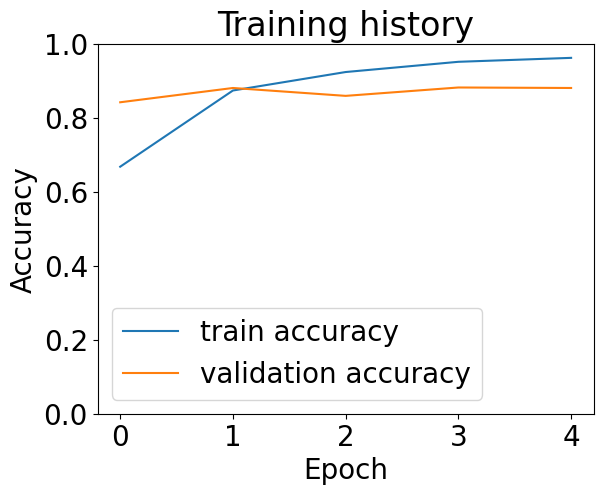

In [59]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

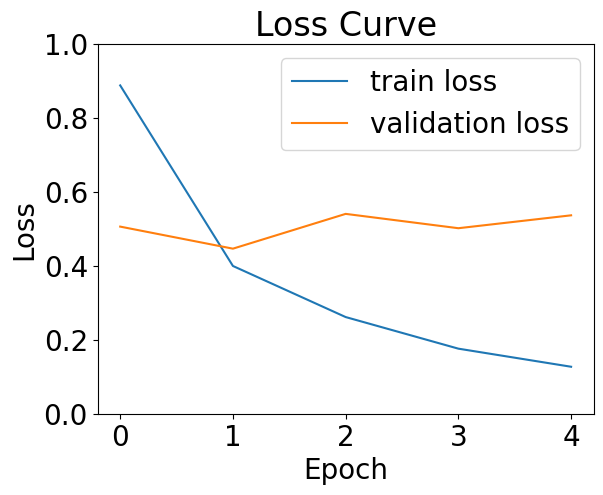

In [60]:
# Loss curve
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

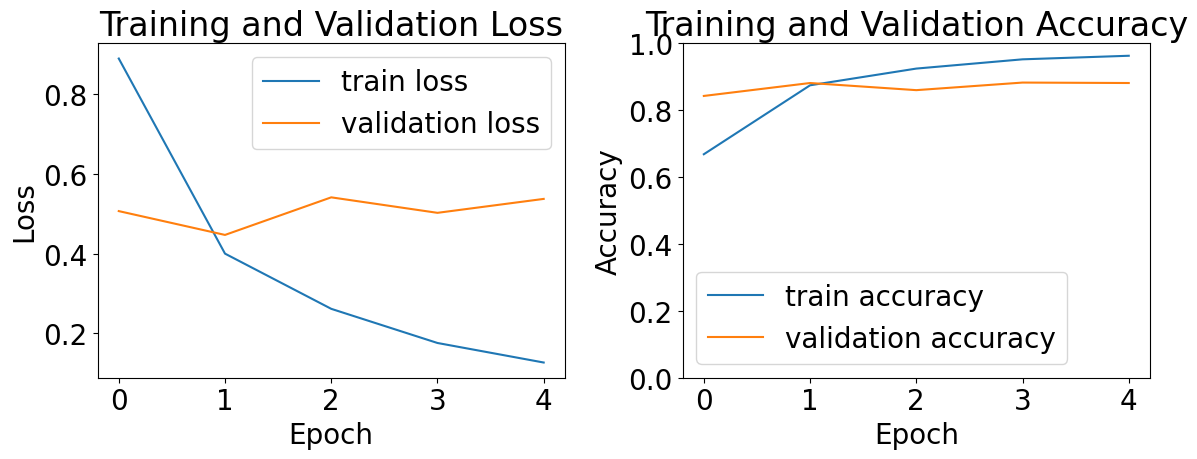

In [61]:
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# BERT_model Class





In [62]:
class Bert_model:
  def __init__(self, model, encoder, tokenizer, maxlen):
    self._model = model
    self._encoder = encoder
    self._tokenizer = tokenizer
    self._device = "cpu"
    self._maxlen = maxlen

  def set_device(self, device):
    self._device = device
    self._model.to(device)

  def _preprocess_text(self, text):
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", text)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      return result

  def _make_prediction_for_text(self, text):
    text = self._preprocess_text(text)
    encoding = self._tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self._maxlen,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(self._device)
    attention_mask = encoding['attention_mask'].to(self._device)
    outputs = self._model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    outputs.to(self._device)
    return outputs.cpu().detach().numpy()

  def detect_emotions_with_labels(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion = self._make_prediction_for_text(text)
      pred = np.argmax(emotion, axis=1)
      prediction = self._encoder.inverse_transform(pred)
      predicted_emotions.append(prediction[0])
    return predicted_emotions

  def detect_emotions_with_proba(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion_proba = self._make_prediction_for_text(text)
      predicted_emotions.append(emotion_proba)
    return np.concatenate(predicted_emotions)

<>:17: SyntaxWarning: invalid escape sequence '\S'
<>:17: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-710182696.py:17: SyntaxWarning: invalid escape sequence '\S'
  result = re.sub('\S*@\S*\s?', '', result)


In [63]:
bert_model = Bert_model(model, label_encoder, tokenizer, maxlen)

In [64]:
bert_model.set_device("cuda")

## Bert model validation

In [65]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_val)
y_true = label_encoder.inverse_transform(emotions_val)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8813333333333333
, precision = 0.8818625051640593
, recall = 0.8813333333333334
, f1_score = 0.8811024919872409



## Bert model testing

In [66]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_test)
y_true = label_encoder.inverse_transform(emotions_test)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8826666666666667
, precision = 0.8827258730640025
, recall = 0.8826666666666668
, f1_score = 0.8821447411084933



In [ ]:
import sys
import os

os.makedirs("logs", exist_ok=True)

with open("logs/bertweet_evaluation_results.txt", "w", encoding="utf-8") as f:
    original_stdout = sys.stdout
    sys.stdout = f

    print("=== VALIDATION RESULTS ===")
    bert_predictions = bert_model.detect_emotions_with_labels(texts_val)
    y_true = label_encoder.inverse_transform(emotions_val)
    compute_metrics(y_true, bert_predictions)

    print("\n=== TEST RESULTS ===")
    bert_predictions = bert_model.detect_emotions_with_labels(texts_test)
    y_true = label_encoder.inverse_transform(emotions_test)
    compute_metrics(y_true, bert_predictions)

    sys.stdout = original_stdout

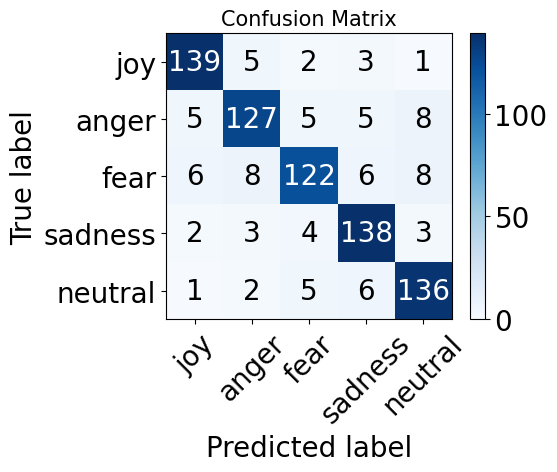

In [68]:
cm = confusion_matrix(y_true, bert_predictions, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 5))

    vmax = cm.max()
    plt.imshow(cm, cmap=plt.cm.Blues, vmin=0, vmax=vmax)
    plt.title("Confusion Matrix", fontsize = "15")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = vmax / 2
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(
                j, i, int(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

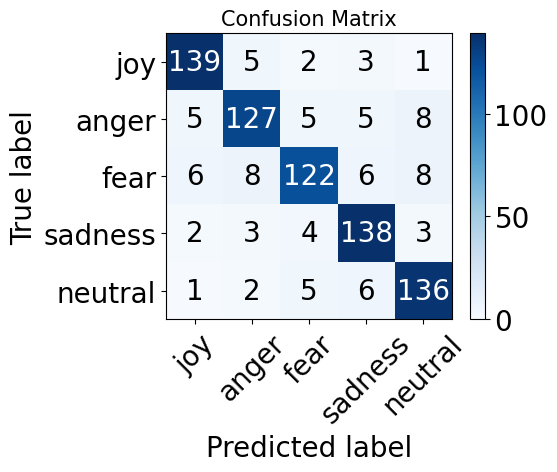

In [70]:
cm = confusion_matrix(y_true, bert_predictions, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [71]:
print(classification_report(y_true, bert_predictions))

              precision    recall  f1-score   support

       anger       0.88      0.85      0.86       150
        fear       0.88      0.81      0.85       150
         joy       0.91      0.93      0.92       150
     neutral       0.87      0.91      0.89       150
     sadness       0.87      0.92      0.90       150

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



In [72]:
from sklearn.metrics import classification_report

log_path = "logs/evaluation_results.txt"

report = classification_report(y_true, bert_predictions)

# print
print(report)

# append file
with open(log_path, "a", encoding="utf-8") as f:
    f.write("\n=== CLASSIFICATION REPORT ===\n")
    f.write(report + "\n")

              precision    recall  f1-score   support

       anger       0.88      0.85      0.86       150
        fear       0.88      0.81      0.85       150
         joy       0.91      0.93      0.92       150
     neutral       0.87      0.91      0.89       150
     sadness       0.87      0.92      0.90       150

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



# Building the ensemble model

## Adding the SVM model to the ensemble model

In [ ]:
class SVM_model:
  def __init__(self, classifier, encoder, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._stop_words = stop_words
    self._vectorizer = vectorizer

  def _preprocess_text(self, text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")
    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "
    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

<>:16: SyntaxWarning: invalid escape sequence '\S'
<>:16: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-3469153161.py:16: SyntaxWarning: invalid escape sequence '\S'
  result = re.sub('\S*@\S*\s?', '', result)


In [ ]:
svm_model = pickle_load_object("svm_model.obj")

## Ensemble model testing

In [ ]:
bert_predictions = bert_model.detect_emotions_with_proba(texts_test)
svm_predictions = svm_model.detect_emotions_with_proba(texts_test)
# combine results for the ensemble model
predictions = svm_predictions+bert_predictions

In [ ]:
y_true = label_encoder.inverse_transform(emotions_test)

In [ ]:
# get labels from ensemble model
predicted_emotions_inv = svm_model.proba_to_labels(predictions)

In [ ]:
acc = accuracy_score(y_true, predicted_emotions_inv)
acc

0.9213333333333333

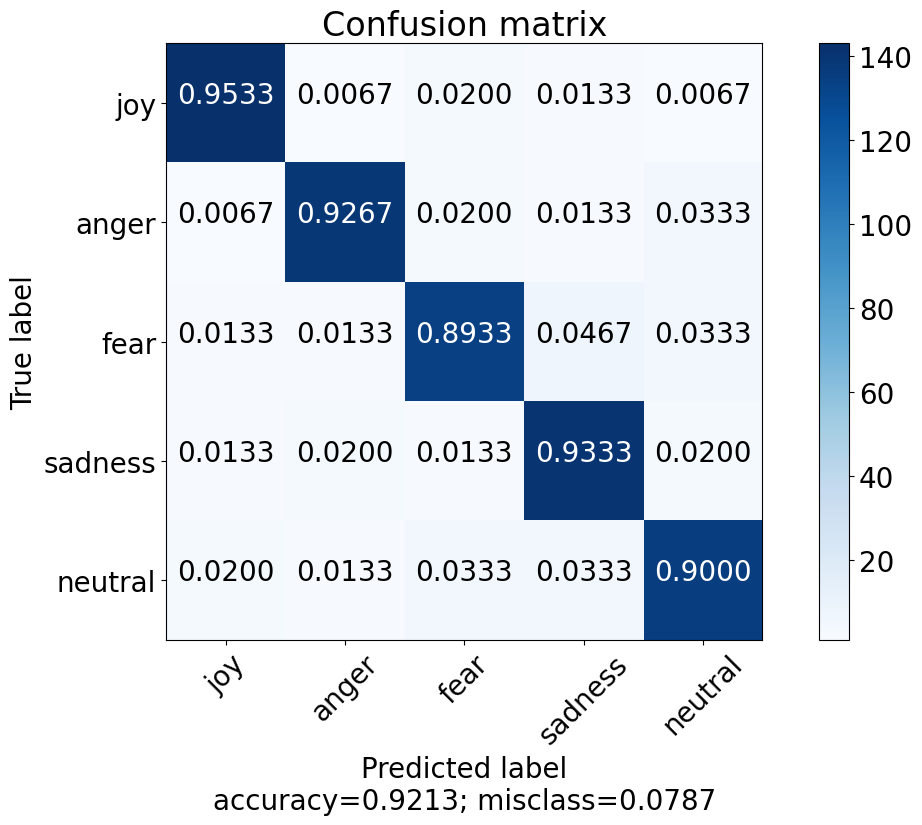

In [ ]:
cm = confusion_matrix(y_true, predicted_emotions_inv, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [ ]:
print(classification_report(y_true, predicted_emotions_inv))

              precision    recall  f1-score   support

       anger       0.95      0.93      0.94       150
        fear       0.91      0.89      0.90       150
         joy       0.95      0.95      0.95       150
     neutral       0.91      0.90      0.90       150
     sadness       0.90      0.93      0.92       150

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



## Ensemble model class

In [ ]:
class Ensemble_Model:
  def __init__(self, bert_model, svm_model):
    self._bert_model = bert_model
    self._svm_model = svm_model

  def set_bert_device(self, device):
    self._bert_model.set_device(device)

  def detect_emotions(self, texts):
    svm_predictions = self._svm_model.detect_emotions_with_proba(texts)
    bert_predictions = self._bert_model.detect_emotions_with_proba(texts)
    predictions = svm_predictions+bert_predictions
    return self._svm_model.proba_to_labels(predictions)


##  Ensemble model validation

In [ ]:
en_model = Ensemble_Model(bert_model, svm_model)

In [ ]:
en_model.set_bert_device("cpu")

In [ ]:
predictions = en_model.detect_emotions(texts_test)

In [ ]:
acc = accuracy_score(df_test.emotion.tolist(), predictions)
acc

0.9213333333333333

In [ ]:
pickle_object(en_model, "english_model.obj")

In [ ]:
predictions = en_model.detect_emotions(["I am sitting home", "New York is a big city", "The president has arrived"])
predictions

[np.str_('neutral'), np.str_('neutral'), np.str_('fear')]

In [ ]:
from transformers import BertTokenizer

# Khởi tạo tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# df['train'] là cột chứa text (tweets)
token_lengths = [
    len(tokenizer.encode(text, add_special_tokens=True))
    for text in df_train['tweet']
]

# Token length tối đa
max_length = max(token_lengths)

print("Maximum token length:", max_length)

Maximum token length: 85


In [ ]:
df_train

,id,tweet,emotion
0,1929,Kinda wished I watched mischievous kiss before...,joy
1,4049,When you forget to mention you were bought dre...,anger
2,5405,@FreyaLynn @donniewahlberg yep! jimmy buffett ...,neutral
3,5900,"@philcampbell blue skies? where, it's still gr...",neutral
4,3712,Some moving clips on youtube tonight of the vi...,anger
...,...,...,...
5995,5407,@koifusionpdx i was so close to the tacos...on...,neutral
5996,496,@Fatumoriginal there's no sitcom better! If u ...,sadness
5997,499,@Mysteri759 @Ren102e906 @slb42jcb @swoozyqyah ...,sadness
5998,1784,Watch this amazing live.ly broadcast by @ittzd...,joy
